### Participant Survey Analysis
This notebook contains code for the participant survey analysis.

In [41]:
# check participant perception of agents, did they feel that they did better or worse with guidance?
import icua_analysis as ia
import pandas as pd
import numpy as np
import itertools

# get demographics data (including self-reported difficulty)
df_demo = ia.load_demographics()
df_demo = df_demo[df_demo["participant"].isin(ia.get_has_eyetracking())]

df_demo = ia.melt_demographics(df_demo)

# replace difficulty with numeric values so we can compute correlations
ests = ['veasy', 'easy', 'moderate', 'hard', 'vhard']
ests = {ests[i]:i for i in range(len(ests))}
df_demo = df_demo.replace(ests) 

dfs = df_demo.groupby('trial')[['participant', 'estimated_difficulty']]
dfs = {group:data.sort_values('participant').reset_index(drop=True).to_numpy()[:,1] for group, data in dfs}

result = pd.DataFrame(columns=['trials', 'Easier', 'Harder', 'Unchanged'])
trials = list(itertools.combinations(['icuA', 'icuaA', 'icuB', 'icuaB'], 2))

for t1, t2 in trials:
    d = dfs[t1] - dfs[t2]
    result.loc[len(result)] = [t1[3:][::-1] + " $\\rightarrow$ " + t2[3:][::-1], (d > 0).sum(), (d < 0).sum(), (d == 0).sum()]

print(result.style.to_latex())


[('icuA', 'icuaA'), ('icuA', 'icuB'), ('icuA', 'icuaB'), ('icuaA', 'icuB'), ('icuaA', 'icuaB'), ('icuB', 'icuaB')]
                trials  Easier  Harder  Unchanged
0   A $\rightarrow$ Aa       1       5          9
1    A $\rightarrow$ B       0      14          1
2   A $\rightarrow$ Ba       0      14          1
3   Aa $\rightarrow$ B       3      12          0
4  Aa $\rightarrow$ Ba       1      13          1
5   B $\rightarrow$ Ba       2       7          6
\begin{tabular}{llrrr}
 & trials & Easier & Harder & Unchanged \\
0 & A $\rightarrow$ Aa & 1 & 5 & 9 \\
1 & A $\rightarrow$ B & 0 & 14 & 1 \\
2 & A $\rightarrow$ Ba & 0 & 14 & 1 \\
3 & Aa $\rightarrow$ B & 3 & 12 & 0 \\
4 & Aa $\rightarrow$ Ba & 1 & 13 & 1 \\
5 & B $\rightarrow$ Ba & 2 & 7 & 6 \\
\end{tabular}



In [26]:
# check participant perception difficulty
import icua_analysis as ia
import pandas as pd
import numpy as np

df_demo = ia.load_demographics()
df_demo = df_demo[df_demo["participant"].isin(ia.get_has_eyetracking())]
df_demo = ia.melt_demographics(df_demo)
counts = df_demo.groupby(['trial', 'estimated_difficulty']).size().reset_index(name='Count')

pivot_table = counts.pivot_table(index='trial', columns='estimated_difficulty', values='Count', fill_value=0)
pivot_table['vhard'] = 0
cols = ['veasy', 'easy', 'moderate', 'hard', 'vhard']
rows = ['icuA', 'icuaA', 'icuB', 'icuaB']

pivot_table = pivot_table[cols].reindex(rows)
print(pivot_table)

latex_str = pivot_table.style.to_latex()
print(latex_str)

estimated_difficulty  veasy  easy  moderate  hard  vhard
trial                                                   
icuA                      6     8         1     0      0
icuaA                     4     7         3     1      0
icuB                      0     4         8     3      0
icuaB                     0     1         8     6      0
\begin{tabular}{lrrrrr}
estimated_difficulty & veasy & easy & moderate & hard & vhard \\
trial &  &  &  &  &  \\
icuA & 6 & 8 & 1 & 0 & 0 \\
icuaA & 4 & 7 & 3 & 1 & 0 \\
icuB & 0 & 4 & 8 & 3 & 0 \\
icuaB & 0 & 1 & 8 & 6 & 0 \\
\end{tabular}



Index(['participant', 'trial', 'failure_proportion',
       'task_failure_length_mean', 'failure_length_mean',
       'task_failure_length_sum', 'failure_length_sum', 'task_failure_count',
       'failure_count'],
      dtype='object')


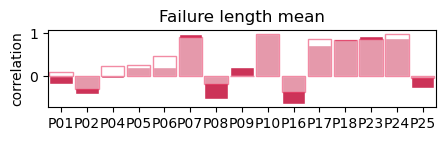

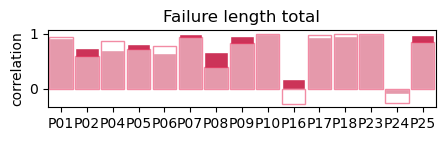

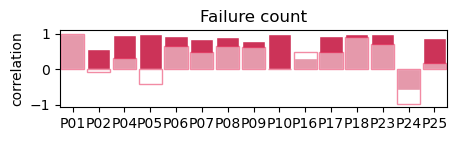

In [33]:
# plot correlation between self-reported performance and actual performance (according to different measures)

import icua_analysis as ia
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce

# get demographics data (including self-reported difficulty)
df_demo = ia.load_demographics()
df_demo = ia.melt_demographics(df_demo)
# replace difficulty with numeric values so we can compute correlations
ests = ['veasy', 'easy', 'moderate', 'hard', 'vhard']
ests = {ests[i]:i for i in range(len(ests))}
df_demo = df_demo.replace(ests) 

# compute scores
df_score = ia.default_performance()
df = pd.merge(df_score, df_demo, on=['participant', 'trial'])

print(df_score.columns)
#print(df.columns)
metrics = [m for m in df_score.columns[3:] if not 'task' in m]

# use these performance metrics
#metrics = ['failure_proportion', 'failure_length_mean', 'failure_count', 'task_failure_length_mean', 'task_failure_count']

def get_corr(df, metric):
    corr = df.groupby('participant')[[metric, 'estimated_difficulty']].corr().reset_index().rename(columns={'estimated_difficulty':'correlation'}).loc[::2][['participant', 'correlation']]
    #corr = corr.rename(columns={'correlation': metric.replace("_", " ").capitalize()})  # Rename the correlation column to the metric name
    return corr

# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# Assuming df is your main DataFrame and get_corr is a function that returns a correlation DataFrame

# plot bar charts
for metric in metrics:
    corr = get_corr(df, metric)
    
    fig = plt.figure(figsize=(5,1))
    ax = sns.barplot(x='participant', y='correlation', data=corr, label="within-task", color="#e6194B",edgecolor="white", alpha = 1, width=0.9)
    task_metric = "task_" + metric
    if task_metric in df.columns:
        corr_task = get_corr(df, "task_" + metric)
        ax = sns.barplot(x='participant', y='correlation', label="task", data=corr_task, color="white", edgecolor="#e6194B", alpha=0.5, width=0.9)
    #ax.set_title(f"{title} correlation of estimated and actual performance")
    metric = metric.replace("sum", "total")
    ax.set_title(metric.replace("_", " ").capitalize())
    ax.set_xlabel(None)
    #plt.legend(bbox_to_anchor=(0.5, -0.3), loc='upper center', ncol=2)
    plt.savefig(f"../result/participant_survey/estimated_actual_correlation_{metric}_nolegend.png", bbox_inches='tight', dpi=300)
    plt.show()